In [ ]:
# Implementation of https://www.roboticsbook.org/S64_driving_perception.html#the-poseslam-factor-graph

In [222]:
import gtsam
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import cv2
import os
from posefinder import VisualOdometry
from gtsam.utils import plot
from numpy.linalg import inv

In [223]:
# Load images for VO
path = "./CUSTOM_sequence/images/"

images = []
print("Loading images")
for fname in tqdm(os.listdir(path)):
        images.append((cv2.imread(os.path.join(path, fname), 0), fname))

# Sort images and remove names after sorting
images = sorted(images, key = lambda x: x[1])
images = list(map(lambda x: x[0], images))

Loading images


100%|██████████| 321/321 [00:04<00:00, 75.18it/s]


In [224]:
# load odometry
odoms = None
with open('odometry.json', 'r') as f:
    odoms = json.load(f)["poses"]

# convert to python arrays
odoms = list(map(lambda x: np.asarray(x), odoms))

In [245]:
graph = gtsam.NonlinearFactorGraph()
prior_model = gtsam.noiseModel.Diagonal.Sigmas((0, 0, 0, 0, 0, 0))
graph.add(gtsam.PriorFactorPose3(1, gtsam.Pose3(np.eye(4)), prior_model))

# Create odometry (Between) factors between consecutive poses
odometry_model = gtsam.noiseModel.Diagonal.Sigmas((0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
Between = gtsam.BetweenFactorPose3
curr_pose = np.eye(4)
poses = [curr_pose]

for ii in range(len(odoms) - 1):
    moved_pose = curr_pose @ odoms[ii]
    graph.add(Between(ii, ii + 1, gtsam.Pose3(odoms[ii]), odometry_model))
    poses.append(moved_pose)
    curr_pose = moved_pose

# Add the loop closure constraint
vo = VisualOdometry()
loops_indexes = [(250, 2), (248,15), (248,14)] # we know that there is a loop between these images

for loops_index_pair in loops_indexes:
    idx_from = loops_index_pair[0] # index of current pose
    idx_to = loops_index_pair[1] # index of matching pose

    ## calculate the delta between these two images using VO 
    loop_gt = vo.pose_from_images(images[idx_to], images[idx_from])
    print(loop_gt)
    graph.add(Between(244, 1, gtsam.Pose3(loop_gt), odometry_model))

Camera Matrix: [[758.44073   0.      604.73553]
 [  0.      759.1989  512.2636 ]
 [  0.        0.        1.     ]]
Distortion Coefficients: [[-3.7764275e-01]
 [ 5.1106185e-01]
 [ 5.8028119e-04]
 [ 2.3433780e-03]
 [-9.0664381e-01]]
[[ 0.9678119   0.04711894 -0.24722447  0.94272634]
 [-0.03480507  0.99793704  0.05394686 -0.20266997]
 [ 0.24925637 -0.04360574  0.96745532  0.26493778]
 [ 0.          0.          0.          1.        ]]
[[ 0.99423786  0.01598145 -0.10599843 -0.30831628]
 [-0.01410092  0.99973003  0.018467   -0.13406898]
 [ 0.10626494 -0.01686592  0.9941948   0.94178903]
 [ 0.          0.          0.          1.        ]]
[[ 0.97182608  0.00909942 -0.2355234   0.52310221]
 [-0.0158789   0.9995119  -0.02690412  0.22706358]
 [ 0.23516363  0.02988598  0.97149621  0.82146592]
 [ 0.          0.          0.          1.        ]]


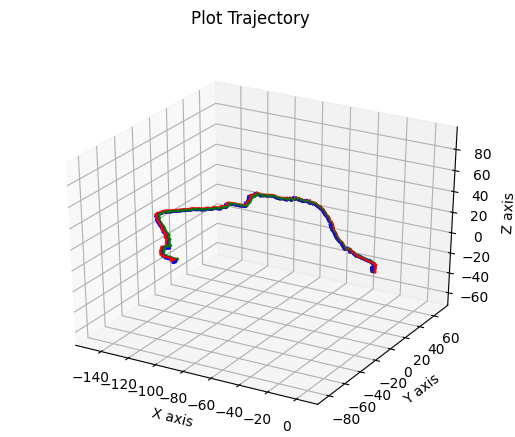

In [246]:
### draw the gt poses 
result = gtsam.Values()
for ii, pose_gt in enumerate(poses):
    result.insert(ii, gtsam.Pose3(pose_gt))

# Plot GT trajectory
plot.plot_trajectory(1, result, scale=1.5)
plot.set_axes_equal(True)
plt.show()

In [247]:
# Create the initial estimate
initial_estimate = gtsam.Values()
for i in range(len(poses)):

    gt_pose = gtsam.Pose3(poses[i])
    initial_estimate.insert(i, gt_pose)

In [248]:
# Optimize the initial values using a Gauss-Newton nonlinear optimizer
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate)
result = optimizer.optimize()

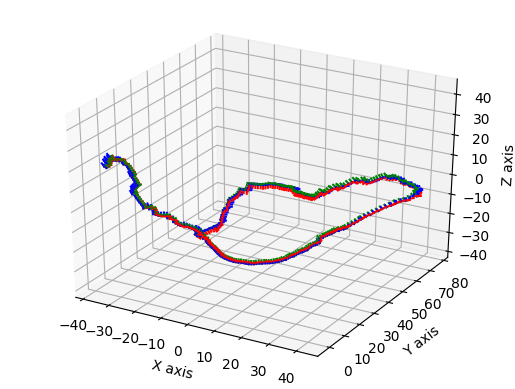

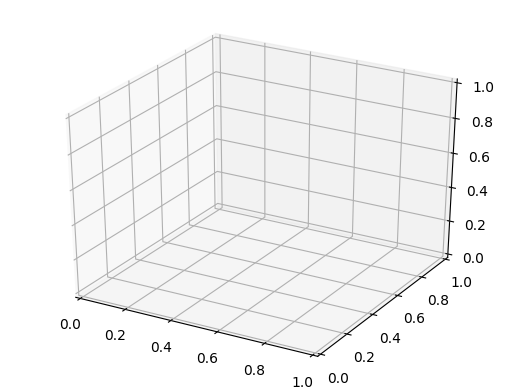

In [249]:
# plot.plot_trajectory(3, result, scale=2.9)
marginals = gtsam.Marginals(graph, result)
plot.plot_incremental_trajectory(3, result, scale=1.5, time_interval=0.1, marginals=marginals)
plot.set_axes_equal(True)
# plt.show()
# print(result)

In [250]:
from lib import plotting
estimated_path = []
original_path = []

print(result.atPose3(0).translation())
for i in range(len(poses)):
    pose = result.atPose3(i)
    estimated_path.append((pose.x(), pose.y()))
    original_path.append((poses[i][0, 3], poses[i][2,3]))
    # estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))

plotting.visualize_paths(estimated_path, estimated_path, "Visual Odometry", file_out=os.path.basename("trajectory") + ".html")

[-0.44826737  0.31304299 -0.83729352]
